In [1]:
import os
os.environ["PROJ_DATA"] = "/home/datacube/micromamba/envs/stac-access/share/proj" # fiona related issue

In [2]:
from pathlib import Path
from datetime import datetime
import pytz
import fiona
import numpy as np
from distributed import Client, performance_report

cwd = Path.cwd()
out_dir = cwd.joinpath('results', 's1_ratio_db_median', 'lrz')
vec = cwd.joinpath('vec', 'malalane.geojson')
now = datetime.now().strftime('%Y%m%dT%H%M')

n_workers = 1
threads_per_worker = 20
mem_limit = "50GB"
dask_client = Client(processes=False, n_workers=n_workers, threads_per_worker=threads_per_worker, memory_limit=mem_limit)

In [3]:
product = 's1_rtc'
measurements = ('vh', 'vv')

time_range = ('2019-01-01', '2020-12-31')
bbox = fiona.open(vec, 'r').bounds
x = (bbox[0], bbox[2])
y = (bbox[1], bbox[3])
output_crs = 'EPSG:4326'
resolution = (-0.0002, 0.0002)
resampling = 'bilinear'

dask_chunks = {'time': 1, 'latitude': 256, 'longitude': 256}
dask_rechunk = {'time': -1}

# 1. STAC metadata - local

In [4]:
from utils import create_in_memory_stac_hierarchy, filter_stac_catalog

catalog = create_in_memory_stac_hierarchy(root_dir=Path("/datacube/original_data/Sentinel1/s1_rtc"))
catalog.make_all_asset_hrefs_absolute()
collections, items = filter_stac_catalog(catalog=catalog, bbox=bbox, time_range=time_range)
len(items)

/home/datacube/micromamba/envs/stac-access/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


169

## 1.1. odc-stac 

In [5]:
%%time
from odc.stac import load as stac_load

data_odcstac_local = stac_load(items, bands=measurements, bbox=bbox, crs=output_crs, resolution=resolution[1],
                               resampling=resampling, chunks=dask_chunks)
data_odcstac_local['ratio_db'] = 10 * np.log10(data_odcstac_local.vh / data_odcstac_local.vv)
data_odcstac_local = data_odcstac_local.chunk(chunks=dask_rechunk)

with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_stac-local-odcstac_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
    result_odcstac_local = data_odcstac_local.ratio_db.median(dim='time', skipna=True).compute()

/home/datacube/micromamba/envs/stac-access/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 9min 26s, sys: 1min 25s, total: 10min 52s
Wall time: 1min 35s


In [6]:
data_odcstac_local.ratio_db

<xarray.DataArray 'ratio_db' (time: 169, latitude: 777, longitude: 1188)>
dask.array<rechunk-merge, shape=(169, 777, 1188), dtype=float32, chunksize=(169, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 -25.38 -25.38 -25.38 ... -25.54 -25.54
  * longitude    (longitude) float64 31.4 31.4 31.4 31.4 ... 31.63 31.63 31.63
    spatial_ref  int32 4326
  * time         (time) datetime64[ns] 2019-01-06T03:18:46.924630 ... 2020-12...

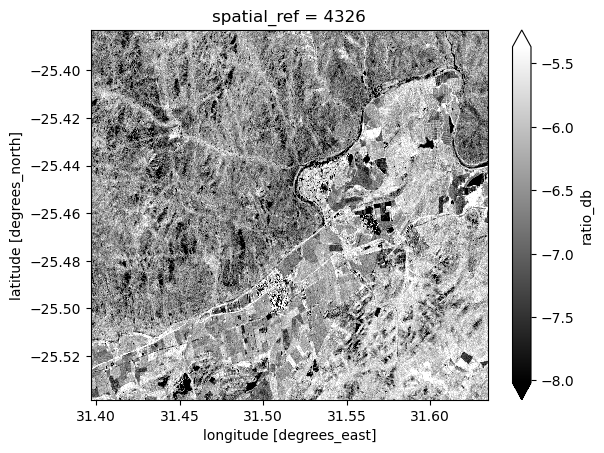

In [7]:
result_odcstac_local.plot(robust=True, cmap='gray')

## 1.2. stackstac

In [8]:
%%time
import stackstac
from rasterio.enums import Resampling

chunksize = (1,) + tuple(dask_chunks.values())
data_stackstac_local = stackstac.stack(items=items, assets=list(measurements), bounds=bbox, epsg=int(output_crs.removeprefix("EPSG:")), 
                                       resolution=resolution[1], resampling=Resampling[resampling], chunksize=chunksize, dtype=np.float32)
vh = data_stackstac_local.sel(band='vh')
vv = data_stackstac_local.sel(band='vv')
data_stackstac_local['ratio_db'] = 10 * np.log10(vh / vv)
data_stackstac_local = data_stackstac_local.chunk(chunks=dask_rechunk)

with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_stac-local-stackstac_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
    result_stackstac_local = data_stackstac_local.ratio_db.median(dim='time', skipna=True).compute()

/home/datacube/micromamba/envs/stac-access/lib/python3.10/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/home/datacube/micromamba/envs/stac-access/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 9min 10s, sys: 37.5 s, total: 9min 48s
Wall time: 1min 59s


In [9]:
data_stackstac_local.ratio_db

<xarray.DataArray 'ratio_db' (time: 169, y: 777, x: 1188)>
dask.array<rechunk-merge, shape=(169, 777, 1188), dtype=float32, chunksize=(169, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/18)
  * time                 (time) datetime64[ns] 2019-01-06T03:18:46.924630 ......
    id                   (time) <U36 dask.array<chunksize=(169,), meta=np.ndarray>
  * x                    (x) float64 31.4 31.4 31.4 31.4 ... 31.63 31.63 31.63
  * y                    (y) float64 -25.38 -25.38 -25.38 ... -25.54 -25.54
    odc:file_format      <U7 'GeoTIFF'
    proj:epsg            int64 4326
    ...                   ...
    platform             <U2 's1'
    common_name          object None
    center_wavelength    object None
    full_width_half_max  object None
    epsg                 int64 4326
    ratio_db             (time, y, x) float32 dask.array<chunksize=(169, 256, 256), meta=np.ndarray>

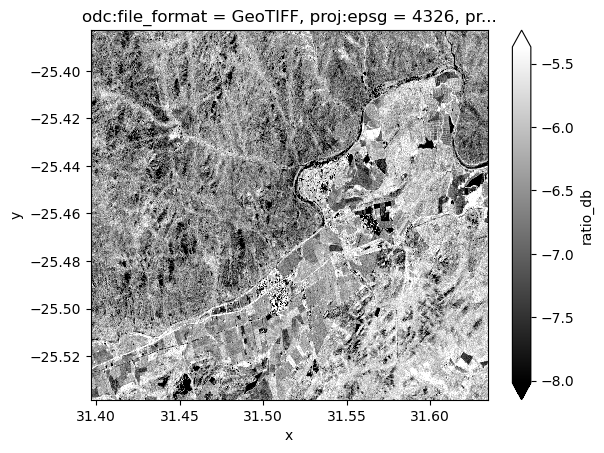

In [10]:
result_stackstac_local.plot(robust=True, cmap='gray')

# 2. STAC metadata - remote - odc-stac

[3] https://odc-stac.readthedocs.io/en/latest/notebooks/stac-load-S2-deafrica.html

In [ ]:
from odc.stac import configure_rio
import pystac_client

configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com", client=dask_client)
remote_catalog = pystac_client.Client.open("https://explorer.digitalearth.africa/stac")
items = remote_catalog.search(bbox=bbox, collections=[product], datetime=f"{time_range[0]}/{time_range[1]}", max_items=None).get_all_items()

In [ ]:
%%time
from odc.stac import load as stac_load

data_odcstac_remote = stac_load(items, bands=measurements, bbox=bbox, crs=output_crs, resolution=resolution[1],
                                resampling=resampling, chunks=dask_chunks)
data_odcstac_remote['ratio_db'] = 10 * np.log10(data_odcstac_remote.vh / data_odcstac_remote.vv)
data_odcstac_remote = data_odcstac_remote.chunk(chunks=dask_rechunk)

with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_stac-remote-odcstac_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
    result_odcstac_remote = data_odcstac_remote.ratio_db.median(dim='time', skipna=True).compute()

In [ ]:
data_odcstac_remote.ratio_db

In [ ]:
result_odcstac_remote.plot(robust=True, cmap='gray')

-----

# 3. EO3 metadata - local - datacube-core

[1] https://github.com/opendatacube/datacube-core   
[2] https://datacube-core.readthedocs.io/en/latest/installation/dataset-documents.html?highlight=eo3#eo3-format

In [11]:
%%time
import datacube
dc = datacube.Datacube()
data_dc_local = dc.load(product=product, measurements=list(measurements), x=x, y=y, time=time_range,
                        output_crs=output_crs, resolution=resolution, resampling=resampling,
                        dask_chunks=dask_chunks)

data_dc_local['ratio_db'] = 10 * np.log10(data_dc_local.vh / data_dc_local.vv)
data_dc_local = data_dc_local.chunk(chunks=dask_rechunk)

with performance_report(filename=out_dir.joinpath(f"{now}_{vec.stem}_eo3-local-datacube_{n_workers}-{threads_per_worker}-{mem_limit}.html")):
    result_dc_local = data_dc_local.ratio_db.median(dim='time', skipna=True).compute()

/home/datacube/micromamba/envs/stac-access/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))


CPU times: user 9min 8s, sys: 1min 4s, total: 10min 13s
Wall time: 1min 21s


In [12]:
data_dc_local.ratio_db

<xarray.DataArray 'ratio_db' (time: 169, latitude: 777, longitude: 1188)>
dask.array<rechunk-merge, shape=(169, 777, 1188), dtype=float32, chunksize=(169, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2019-01-06T03:18:46.924630 ... 2020-12...
  * latitude     (latitude) float64 -25.38 -25.38 -25.38 ... -25.54 -25.54
  * longitude    (longitude) float64 31.4 31.4 31.4 31.4 ... 31.63 31.63 31.63
    spatial_ref  int32 4326

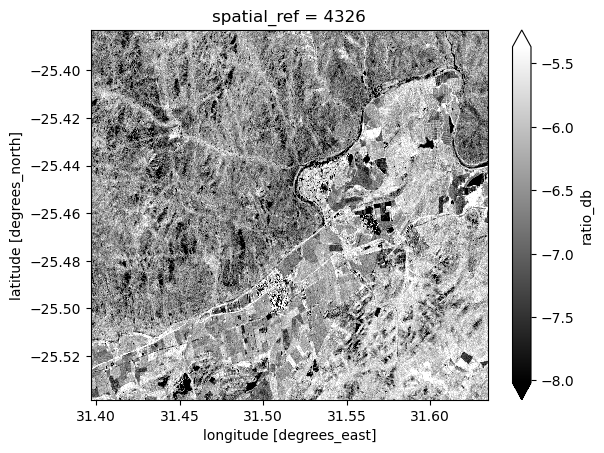

In [13]:
result_dc_local.plot(robust=True, cmap='gray')

# Additional information

In [14]:
import datacube
import odc.stac
import odc.geo
import stackstac
import rasterio
import pystac
import pystac_client
print(f"datacube=={datacube.__version__}")
print(f"odc.stac=={odc.stac.__version__}")
print(f"odc.geo=={odc.geo.__version__}")
print(f"stackstac=={stackstac.__version__}")
print(f"rasterio=={rasterio.__version__}")
print(f"pystac=={pystac.__version__}")
print(f"pystac_client=={pystac_client.__version__}")

datacube==1.8.12
odc.stac==0.3.5
odc.geo==0.3.3
stackstac==0.4.3
rasterio==1.3.6
pystac==1.7.3
pystac_client==0.6.1


In [15]:
!lscpu | grep -v "Vulnerability" | grep -v "Flags" 

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 57 bits virtual
CPU(s):                          40
On-line CPU(s) list:             0-39
Thread(s) per core:              1
Core(s) per socket:              1
Socket(s):                       40
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           106
Model name:                      Intel(R) Xeon(R) Silver 4316 CPU @ 2.30GHz
Stepping:                        6
CPU MHz:                         2294.562
BogoMIPS:                        4589.12
Virtualization:                  VT-x
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       1.3 MiB
L1i cache:                       1.3 MiB
L2 cache:                        160 MiB
L3 cache:                        64